# Question Answering Bot Fine-Tuned Using SQuAD Dataset

### Introduction (reasoning behind the project)
At the beginning of this week we configured a profile on the hugging face website.  We learned that this website seems to be a very close equivalent to github except for it mainly hosts models and datasets instead of hosting code solutions!  Upon learning this we were very interested and so in this notebook we try to create our own fine-tune model that others could download and use.  

It also allows you to start and stop training a network (even from different devices and different times) and pushes your current state up to the cloud for you to grab later to keep training!  This is actually what we did in this notebook since the model took a really long time to fine tune and we were running out of google colab GPU on different accounts (with google colab it was taking roughly 2 hours per epoch of fine-tuning with gpu and unfathomably long without).  Below we can see an image of the hugging face account we pulled and pushed our model to throughout our fine-tuning process using colab.

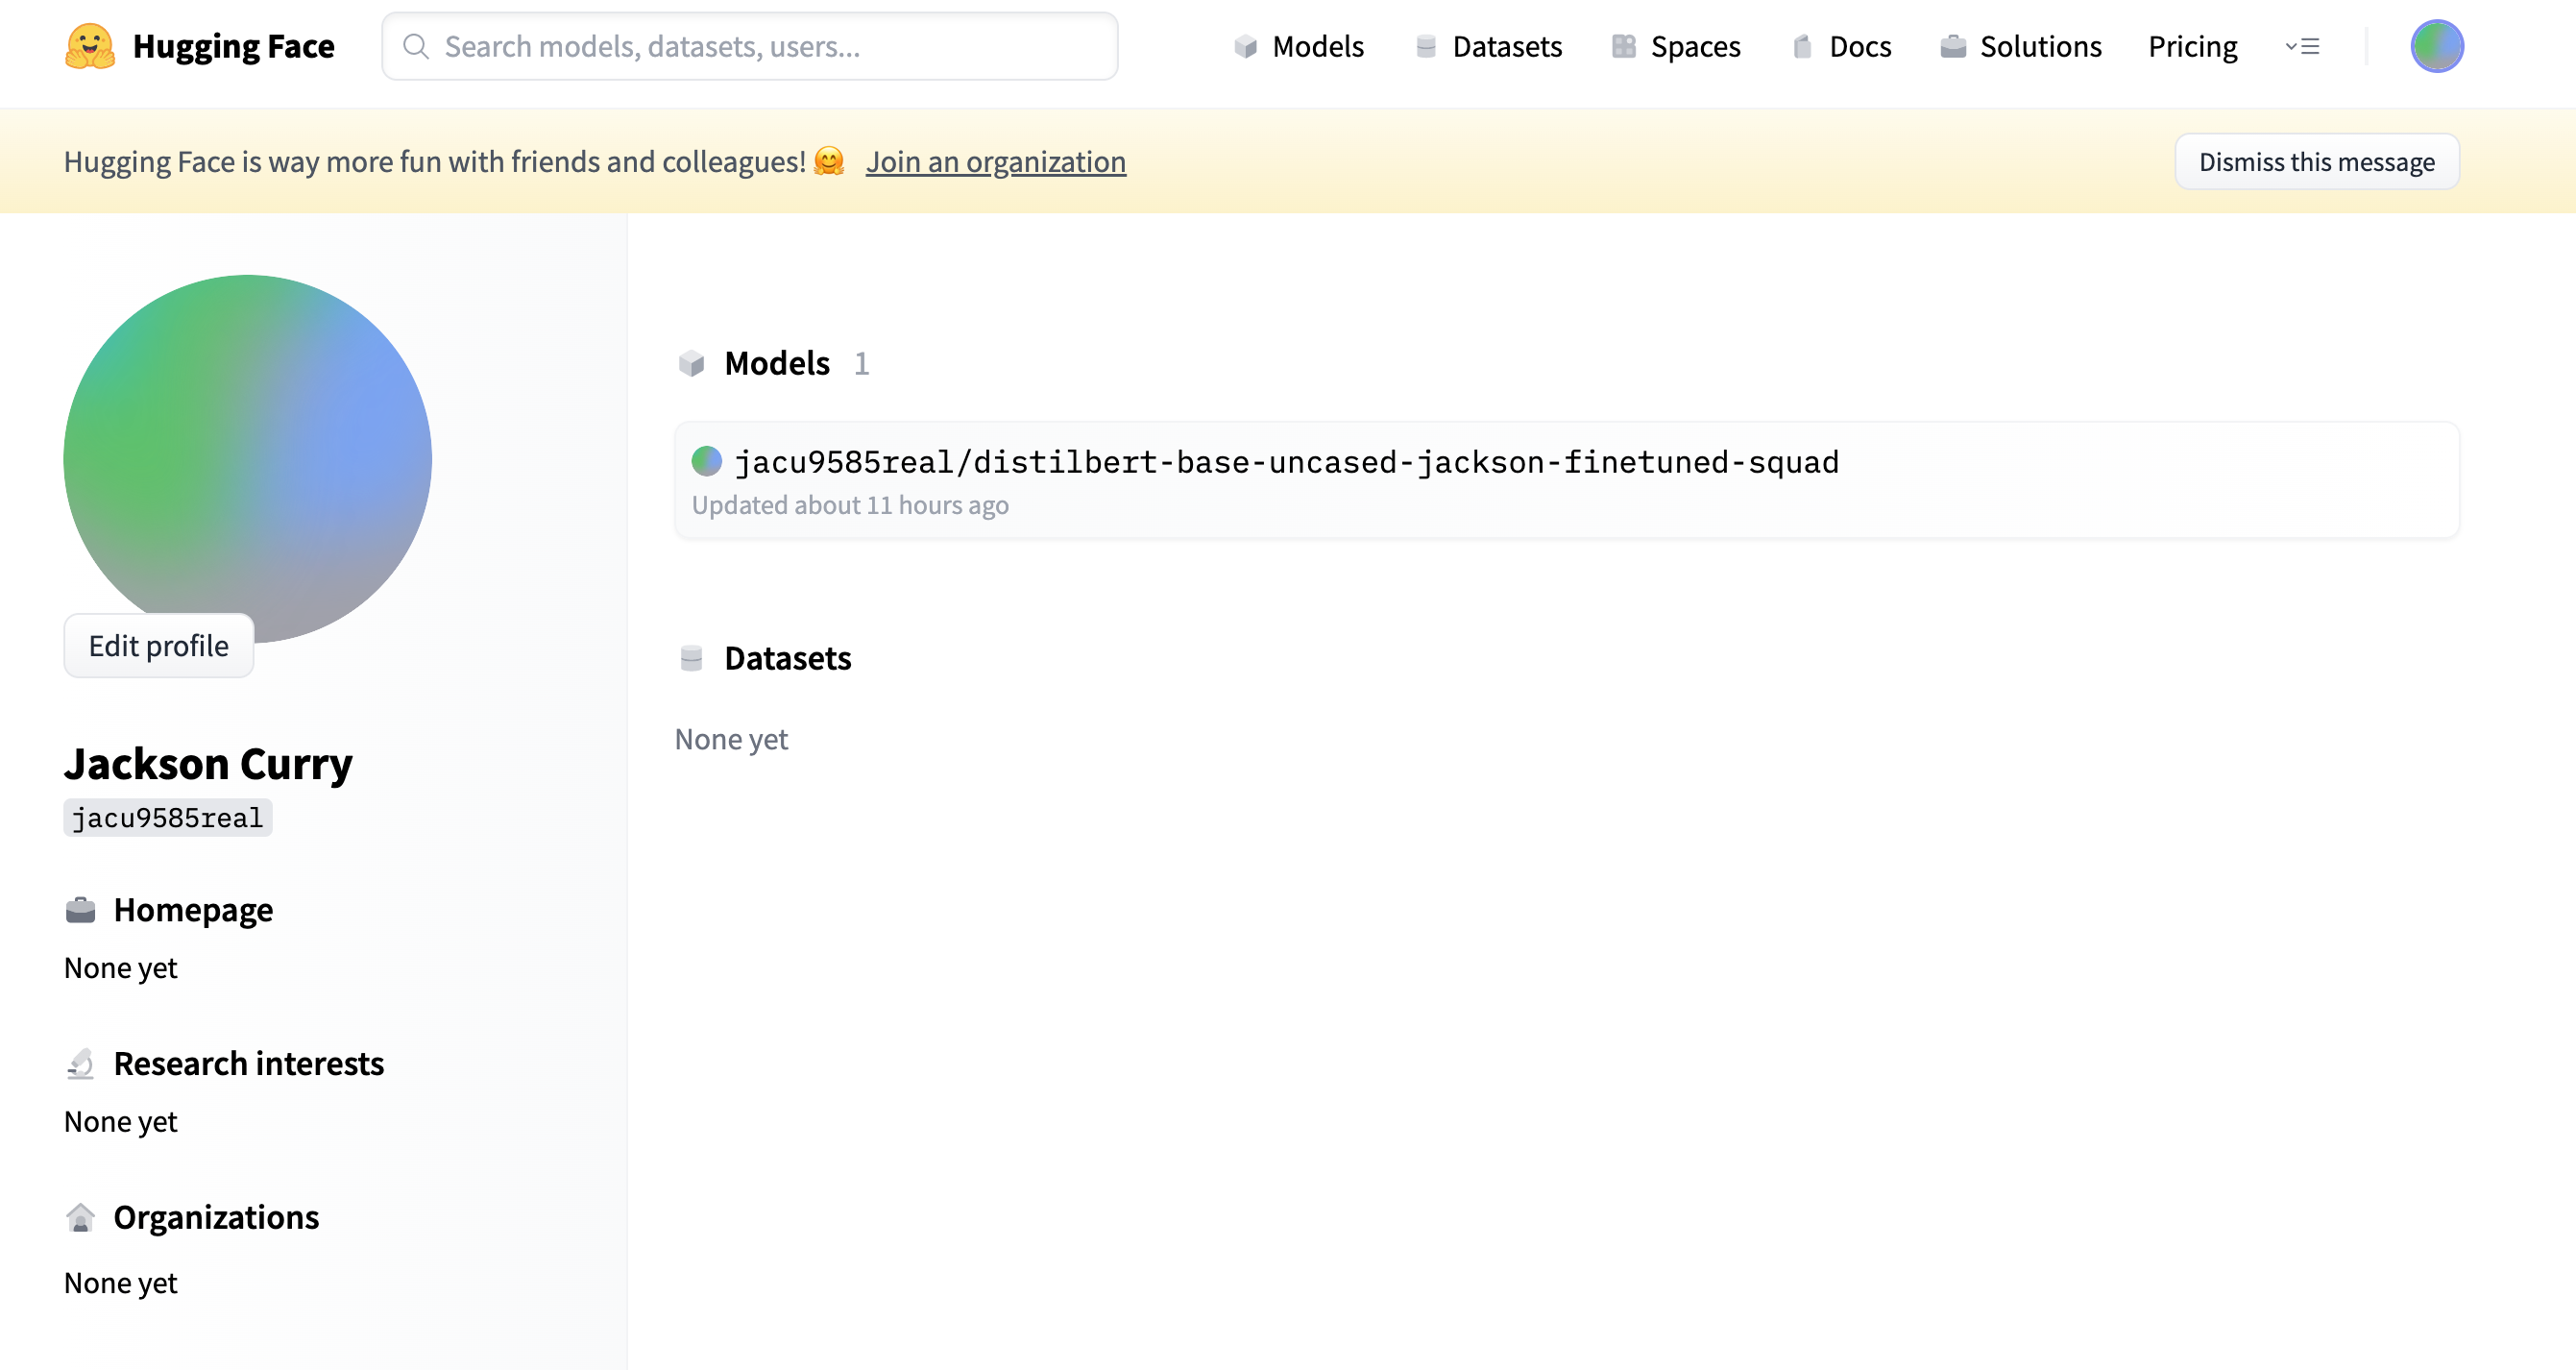

We recognize that in this notebook we are diving deeper into a topic that was mainly covered in class right around when the previous notebook was due.  However our interest in the topic of creating a question answering model, the SQuAD datasets, and the hugging face community (https://huggingface.co/) was what made us want to spend more time developing and understanding these topics in this notebook!


### Quick Overview

In this notebook, we will see how to fine-tune one of the hugging face Transformers models (in our case we pulled down "distilbert-base-uncased") to the downstream task of question answering. Specifically with the SQuAD datasets, this is the task of extracting the answer to a question from a given context. Note that this model does not generate new text! Instead, it selects a span of the input passage as the answer.

### Distinction Between SQuAD and SQuAD2.0
SQuAD --> This is a dataset with 100k reading comprehension questions.  Essentially the computer is given a question to answer along with a long passage of text (which contains the answer).  From this we assess whether the computer is able to answer the question correctly!  In this notebook we will be using this dataset to fine-tune for the downstream task.

SQuAD2.0 --> This is the same dataset as before except there are an additional 50k unanswerable questions that were written adversarially by crowdworkers to look similar to answerable ones.  For a model to succeed here it mus be able to not only give answers to the questions when possible but also refuse to give an answer in these scenarios!

## Part 1:  Loading Pretrained Model from Hugging Face

In [2]:
#RUN THE FOLLOWING IN GOOGLE COLAB THE FIRST RUNTHROUGH!
#OR IF FROM REGULAR JUPYTER NOTEBOOK THEN JUST INSTALL THESE IN 
#YOUR VIRTUAL ENVIRONMENT
! pip install transformers datasets huggingface_hub

  Using cached datasets-1.18.4-py3-none-any.whl (312 kB)
  Using cached responses-0.18.0-py3-none-any.whl (38 kB)
     |████████████████████████████████| 20.2 MB 5.2 MB/s eta 0:00:01
  Using cached fsspec-2022.2.0-py3-none-any.whl (134 kB)
  Using cached dill-0.3.4-py2.py3-none-any.whl (86 kB)
     |████████████████████████████████| 128 kB 40.6 MB/s eta 0:00:01
     |████████████████████████████████| 574 kB 13.6 MB/s eta 0:00:01
     |████████████████████████████████| 76 kB 12.2 MB/s eta 0:00:01
  Using cached aiosignal-1.2.0-py3-none-any.whl (8.2 kB)
     |████████████████████████████████| 121 kB 23.4 MB/s eta 0:00:01
  Using cached async_timeout-4.0.2-py3-none-any.whl (5.8 kB)
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.59.0
    Uninstalling tqdm-4.59.0:
      Successfully uninstalled tqdm-4.59.0
  Attempting uninstall: fsspec
    Found existing installation: fsspec 0.9.0
    Uninstalling fsspec-0.9.0:
      Successfully uninstalled fsspec-0.9.0


Below is the method we learned to login to hugging face over google colab!  We also had to learn how to generate read tokens (in order to pull datasets and pretrained models down) and write tokens (in order to put our own fine-tuned model up onto their website for others to pull down and use)!

You must enter either a read or write token into the field below after running the cell (and we found out you can find your read/write tokens in the settings section of your accout).

In [3]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /Users/jacksoncurry/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


Below we install git large file storage! (only needs to be ran once)

In [57]:
pass
#!apt install git-lfs
#!git config --global user.email "jacu9585@colorado.edu"
#!git config --global user.name "jacu9585"

Below are our imports for this project.  We print the transformers version below to ensure that it is at least 4.17.0 which ensures that our hugging face version is up to date far enough!

In [5]:
#Imports:
#General Imports
from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML
#All Imports for Tensorflow

#All Imports for Hugging Face
import transformers
from transformers import AutoTokenizer
from transformers import TFAutoModelForQuestionAnswering
#printing the version of transformers package (should be 4.17.0.dev0)!!!
print(transformers.__version__)

4.17.0.dev0


Below is where we can select whether we want to use SQuAD or SQuAD2.0 for fine tuning our pretrained model. 

In this cell we also choose which pretrained model we want to download from hugging face as a starting point to fine-tune for this specific question answering task!

Finally we declare the batch_size that will be used in the fine-tuning process!

In [6]:
# Flag for using squad2.0 dataset!  We have it set to False because for now we just want the original squad dataset!
squad_v2 = False
model_checkpoint = "distilbert-base-uncased" #this is how you load in th original model before any additional
                                             #fine-tuning training has been done!
batch_size = 16

## Part 2: EDA and Preprocessing on SQuAD Dataset

Below we get import the functions that allow us to load any dataset off of the hugging face library along with its corresponding error metric!  This makes it much easier to fine tune our model on a wide variety of different datasets!

In [7]:
from datasets import load_dataset, load_metric

Below is where we actually load in the dataset (it was already defined above that we will be loading in the squad dataset for now, but this should show how easy it would be to transition to squadv2 if we wanted)

In [8]:
datasets = load_dataset("squad_v2" if squad_v2 else "squad")

Downloading:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/8.12M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.05M [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset squad downloaded and prepared to /Users/jacksoncurry/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Below we print out the training and validation part of the dataset. We can see the training, validation and test sets all have a column for the context, the question and the answers to those questions.

In [9]:
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

Below we print out a single element in the training set.  We can see the question that the computer must answer, the context passage it is given, and the answer that is desired!

In [10]:
datasets["train"][0]

{'id': '5733be284776f41900661182',
 'title': 'University_of_Notre_Dame',
 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'answers': {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}}

We can see the answers are indicated by their start position in the text (here at character 515) and their full text, which is a substring of the context as we mentioned above.  To get a sense of what the data looks like, the following function will show some examples picked randomly from the dataset and decoded back to strings.

In [17]:
def showRandomElementsFromSQuAD(dataset, num_examples=10):
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset) - 1)
        while pick in picks:
            pick = random.randint(0, len(dataset) - 1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    df.head(10) 

In [18]:
showRandomElementsFromSQuAD(datasets["train"])

,id,title,context,question,answers
0,56fddf75761e401900d28c17,Computer,"By 1938 the United States Navy had developed an electromechanical analog computer small enough to use aboard a submarine. This was the Torpedo Data Computer, which used trigonometry to solve the problem of firing a torpedo at a moving target. During World War II similar devices were developed in other countries as well.",What part of the US military developed an electromechanical analog computer to use on a submarine?,"{'text': ['the United States Navy'], 'answer_start': [8]}"
1,57260f15ec44d21400f3d86c,Buckingham_Palace,"Various owners leased it from royal landlords and the freehold was the subject of frenzied speculation during the 17th century. By then, the old village of Eye Cross had long since fallen into decay, and the area was mostly wasteland. Needing money, James I sold off part of the Crown freehold but retained part of the site on which he established a 4-acre (16,000 m2) mulberry garden for the production of silk. (This is at the northwest corner of today's palace.) Clement Walker in Anarchia Anglicana (1649) refers to ""new-erected sodoms and spintries at the Mulberry Garden at S. James's""; this suggests it may have been a place of debauchery. Eventually, in the late 17th century, the freehold was inherited from the property tycoon Sir Hugh Audley by the great heiress Mary Davies.",Which village had fallen into decay but the 17th century?,"{'text': ['Eye Cross'], 'answer_start': [156]}"
2,5728f5716aef0514001548cc,Samurai,"In December 1547, Francis was in Malacca (Malaysia) waiting to return to Goa (India) when he met a low-ranked samurai named Anjiro (possibly spelled ""Yajiro""). Anjiro was not an intellectual, but he impressed Xavier because he took careful notes of everything he said in church. Xavier made the decision to go to Japan in part because this low-ranking samurai convinced him in Portuguese that the Japanese people were highly educated and eager to learn. They were hard workers and respectful of authority. In their laws and customs they were led by reason, and, should the Christian faith convince them of its truth, they would accept it en masse.",Who impressed Xavier by taking notes in church?,"{'text': ['Anjiro'], 'answer_start': [160]}"
3,57266767f1498d1400e8de7e,Botany,"Another work from Ancient Greece that made an early impact on botany is De Materia Medica, a five-volume encyclopedia about herbal medicine written in the middle of the first century by Greek physician and pharmacologist Pedanius Dioscorides. De Materia Medica was widely read for more than 1,500 years. Important contributions from the medieval Muslim world include Ibn Wahshiyya's Nabatean Agriculture, Abū Ḥanīfa Dīnawarī's (828–896) the Book of Plants, and Ibn Bassal's The Classification of Soils. In the early 13th century, Abu al-Abbas al-Nabati, and Ibn al-Baitar (d. 1248) wrote on botany in a systematic and scientific manner.",What was the profession of the man who wrote De Materia Medica?,"{'text': ['physician and pharmacologist'], 'answer_start': [192]}"
4,5728ccb74b864d1900164e54,London,"London is home to many museums, galleries, and other institutions, many of which are free of admission charges and are major tourist attractions as well as playing a research role. The first of these to be established was the British Museum in Bloomsbury, in 1753. Originally containing antiquities, natural history specimens and the national library, the museum now has 7 million artefacts from around the globe. In 1824 the National Gallery was founded to house the British national collection of Western paintings; this now occupies a prominent position in Trafalgar Square.",When was the British Museum in Bloomsbury founded?,"{'text': ['1753'], 'answer_start': [259]}"
5,5726872b5951b619008f75c4,Data_compression,"If the data to be compressed is analog (such as a voltage that varies with time), quantization is employed to digitize it into numbers (normally integers). This is

## Preprocessing the training data

Before we can feed those texts to our model, we need to preprocess them. To do all of this, we instantiate our tokenizer with the `AutoTokenizer.from_pretrained` method, which will ensure:

- we get a tokenizer that corresponds to the model architecture we want to use,
- we download the vocabulary used when pretraining this specific checkpoint.

In [21]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

The following assertion ensures that our tokenizer is a fast tokenizer from the hugging face Tokenizers library that we looked at last week (we know that usually each model aka bert/gpt2/... have their own tokenizer. Those fast tokenizers are available for almost all models on hugging face, and we need the fast version vfor our preprocessing.  Also we recommend looking at the following table in order to see which types of models have fast tokenizers available and which don't! [big table of models](https://huggingface.co/transformers/index.html#bigtable) from hugging face

In [22]:
import transformers

assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

You can directly call this tokenizer on two sentences (one for the answer, one for the context):

In [58]:
tokenizer("What is your name?", "My name is Jackson Curry.")

{'input_ids': [101, 2054, 2003, 2115, 2171, 1029, 102, 2026, 2171, 2003, 4027, 15478, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Now one specific thing for the preprocessing in question answering is how to deal with very long documents. In other tasks we can usually truncate them, but here, removing part of the the context might result in losing the answer we are looking for!!!

To deal with this, we will allow one "long" example in our dataset to give several input features, each of length shorter than the maximum length of the model (or the one we set as a hyper-parameter)

In [24]:
max_length = 384  # The maximum length of a feature (question and context)
doc_stride = 128  # The allowed overlap between two part of the context when splitting is performed.

Let's find a "long" example in our dataset by looking for one that is larger than the max_length we just defined above:

In [25]:
for i, example in enumerate(datasets["train"]):
    if len(tokenizer(example["question"], example["context"])["input_ids"]) > 384:  #max_length from above!
        break
example = datasets["train"][i]

Without any truncation, we get the following length for the input IDs:

In [26]:
len(tokenizer(example["question"], example["context"])["input_ids"])

396

Now, if we just truncate, we will lose information (and possibly the answer to our question):

In [27]:
len(
    tokenizer(
        example["question"],
        example["context"],
        max_length=max_length,
        truncation="only_second",
    )["input_ids"]
)

384

Note that we never want to truncate the question, only the context, and so we use the `only_second` truncation method in order to do this!

In [28]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    stride=doc_stride,
)

Now we don't have one list of `input_ids`, but several: 

In [29]:
[len(x) for x in tokenized_example["input_ids"]]

[384, 157]

And if we decode them, we can see the overlap:

In [30]:
for x in tokenized_example["input_ids"][:2]:
    print(tokenizer.decode(x))

[CLS] how many wins does the notre dame men's basketball team have? [SEP] the men's basketball team has over 1, 600 wins, one of only 12 schools who have reached that mark, and have appeared in 28 ncaa tournaments. former player austin carr holds the record for most points scored in a single game of the tournament with 61. although the team has never won the ncaa tournament, they were named by the helms athletic foundation as national champions twice. the team has orchestrated a number of upsets of number one ranked teams, the most notable of which was ending ucla's record 88 - game winning streak in 1974. the team has beaten an additional eight number - one teams, and those nine wins rank second, to ucla's 10, all - time in wins against the top team. the team plays in newly renovated purcell pavilion ( within the edmund p. joyce center ), which reopened for the beginning of the 2009 – 2010 season. the team is coached by mike brey, who, as of the 2014 – 15 season, his fifteenth at notr

Next we need to properly label the answers here: we need to find in which of those features the answer actually is, and where exactly in that feature. The models we will use require the start and end positions of these answers in the tokens, so we will also need to to map parts of the original context to some tokens. Thankfully, the tokenizer we're using can help us with that by returning an `offset_mapping`

In [31]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    stride=doc_stride,
)
print(tokenized_example["offset_mapping"][0][:100])

[(0, 0), (0, 3), (4, 8), (9, 13), (14, 18), (19, 22), (23, 28), (29, 33), (34, 37), (37, 38), (38, 39), (40, 50), (51, 55), (56, 60), (60, 61), (0, 0), (0, 3), (4, 7), (7, 8), (8, 9), (10, 20), (21, 25), (26, 29), (30, 34), (35, 36), (36, 37), (37, 40), (41, 45), (45, 46), (47, 50), (51, 53), (54, 58), (59, 61), (62, 69), (70, 73), (74, 78), (79, 86), (87, 91), (92, 96), (96, 97), (98, 101), (102, 106), (107, 115), (116, 118), (119, 121), (122, 126), (127, 138), (138, 139), (140, 146), (147, 153), (154, 160), (161, 165), (166, 171), (172, 175), (176, 182), (183, 186), (187, 191), (192, 198), (199, 205), (206, 208), (209, 210), (211, 217), (218, 222), (223, 225), (226, 229), (230, 240), (241, 245), (246, 248), (248, 249), (250, 258), (259, 262), (263, 267), (268, 271), (272, 277), (278, 281), (282, 285), (286, 290), (291, 301), (301, 302), (303, 307), (308, 312), (313, 318), (319, 321), (322, 325), (326, 330), (330, 331), (332, 340), (341, 351), (352, 354), (355, 363), (364, 373), (374,

This gives the corresponding start and end character in the original text for each token in our input IDs. The very first token (`[CLS]`) has (0, 0) because it doesn't correspond to any part of the question/answer, then the second token is the same as the characters 0 to 3 of the question

In [32]:
first_token_id = tokenized_example["input_ids"][0][1]
offsets = tokenized_example["offset_mapping"][0][1]
print(
    tokenizer.convert_ids_to_tokens([first_token_id])[0],
    example["question"][offsets[0] : offsets[1]],
)

how How


So we can use this mapping to find the position of the start and end tokens of our answer in a given feature. We just have to distinguish which parts of the offsets correspond to the question and which part correspond to the context, this is where the `sequence_ids` method of our `tokenized_example` can be useful:

In [33]:
sequence_ids = tokenized_example.sequence_ids()
print(sequence_ids)

[None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

It returns `None` for the special tokens, then 0 or 1 depending on whether the corresponding token comes from the first sentence past (the question) or the second (the context). Now with all of this, we can find the first and last token of the answer in one of our input feature (or if the answer is not in this feature):

In [34]:
answers = example["answers"]
start_char = answers["answer_start"][0]
end_char = start_char + len(answers["text"][0])

# Start token index of the current span in the text.
token_start_index = 0
while sequence_ids[token_start_index] != 1:
    token_start_index += 1

# End token index of the current span in the text.
token_end_index = len(tokenized_example["input_ids"][0]) - 1
while sequence_ids[token_end_index] != 1:
    token_end_index -= 1

# Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
offsets = tokenized_example["offset_mapping"][0]
if (
    offsets[token_start_index][0] <= start_char
    and offsets[token_end_index][1] >= end_char
):
    # Move the token_start_index and token_end_index to the two ends of the answer.
    # Note: we could go after the last offset if the answer is the last word (edge case).
    while (
        token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char
    ):
        token_start_index += 1
    start_position = token_start_index - 1
    while offsets[token_end_index][1] >= end_char:
        token_end_index -= 1
    end_position = token_end_index + 1
    print(start_position, end_position)
else:
    print("The answer is not in this feature.")

23 26


And we can verify that it is the correct answer:

In [35]:
print(
    tokenizer.decode(
        tokenized_example["input_ids"][0][start_position : end_position + 1]
    )
)
print(answers["text"][0])
pad_on_right = tokenizer.padding_side == "right"

over 1, 600
over 1,600


This function below is what we will apply to the training set before using it in fine-tuning training!  If we were to be using SQuAD2.0 dataset then we would need to set the flag `allow_impossible_answers` is `True`. However we just wanted to do the SQuAD dataset to make things easier so we set this flag to `False`.

In [37]:
def prepare_train_features(examples):
    # Tokenize our examples with truncation and padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1

            if not (
                offsets[token_start_index][0] <= start_char
                and offsets[token_end_index][1] >= end_char
            ):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while (
                    token_start_index < len(offsets)
                    and offsets[token_start_index][0] <= start_char
                ):
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

This function works with one or several examples. In the case of several examples, the tokenizer will return a list of lists for each key:

In [38]:
features = prepare_train_features(datasets["train"][:5])

To apply this function on all the sentences (or pairs of sentences) in our dataset, we just use the `map` method of the `dataset` object we created earlier. This will apply the function on all the elements of all the splits in `dataset`, so our training, validation and testing data will be preprocessed in one single command. Since our preprocessing changes the number of samples, we need to remove the old columns when applying it.

In [39]:
tokenized_datasets = datasets.map(
    prepare_train_features, batched=True, remove_columns=datasets["train"].column_names
)

  0%|          | 0/88 [00:00<?, ?ba/s]

  0%|          | 0/11 [00:00<?, ?ba/s]

Also from what we learned reading the documentation of hugging face, we saw that the results are automatically cached by the hugging face Datasets library to avoid spending time on this step the next time you run your notebook.  This could be visibly seen between when we would run the cell the first time vs the second time!

## Part 3: Fine-tuning the model

Now that our data is ready for training we can download the pretrained model and fine-tune it. Since our task is question answering, we use the `TFAutoModelForQuestionAnswering` class. Similar the the tokenizer we can use the  `from_pretrained` method will download and cache the model for us.  Currently we have our model_checkpoint set to what you should have when first running the notebook and starting from "distilbert-base-uncased" which is readily available!

In [40]:
model = TFAutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForQuestionAnswering: ['activation_13', 'vocab_transform', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'qa_outputs']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The first two arguments below are to setup everything so we can push the model to the [Hub](https://huggingface.co/models) at the end of training. 

Also we can tweak the learning rate, use the `batch_size` defined at the top of the notebook and customize the number of epochs for training, as well as the weight decay.

In [41]:
model_name = model_checkpoint.split("/")[-1]
push_to_hub_model_id = f"{model_name}-finetuned-squad-jackson-test"
learning_rate = 2e-5
num_train_epochs = 2
weight_decay = 0.01

Then we will need a data collator that will batch our processed examples together, here the default one will work.

In [42]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator(return_tensors="tf")
train_set = tokenized_datasets["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "start_positions", "end_positions"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)
validation_set = tokenized_datasets["validation"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "start_positions", "end_positions"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

Next, we can create an optimizer and specify a loss function. The `create_optimizer` function gives us a very solid optimizer with weight decay and a learning rate schedule, but we learned that it needs us to compute the number of training steps to build that schedule.

In [44]:
from transformers import create_optimizer

total_train_steps = (len(tokenized_datasets["train"]) // batch_size) * num_train_epochs

optimizer, schedule = create_optimizer(
    init_lr=learning_rate, num_warmup_steps=0, num_train_steps=total_train_steps
)

As for the loss, all Transformers models compute loss internally, so we can simple leave the loss argument empty to train on this internal loss.

This is very different from the standard way that Keras usually handles losses! From looking it up to refresh we saw that Keras usually has labels passed separately and not visible to the main body of the model, and loss is handled by a function that the user passes to `compile()`, which uses the model outputs and the label to compute a loss value.

Instead hugging face Transformer models are capable of computing an appropriate loss for their task internally (for example, a CausalLM model will use a cross-entropy loss). To do this, the labels must be provided in the input dict (or equivalently, in the `columns` argument to `to_tf_dataset()`), so that they are visible to the model during the forward pass.

In [45]:
import tensorflow as tf

model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! Please ensure your labels are passed as keys in the input dict so that they are accessible to the model during the forward pass. To disable this behaviour, please pass a loss argument, or explicitly pass loss=None if you do not want your model to compute a loss.


We will evaluate our model and compute metrics in the next section (this is a very long operation, so we will only compute the evaluation loss during training). For now, let's just train our model. We also add the callback to sync up our model with the Hub (allowing us to resume trainig from other machines)

In [34]:
from transformers.keras_callbacks import PushToHubCallback
from tensorflow.keras.callbacks import TensorBoard

push_to_hub_callback = PushToHubCallback(
    output_dir="./qa_model_save",
    tokenizer=tokenizer,
    hub_model_id=push_to_hub_model_id,
)

tensorboard_callback = TensorBoard(log_dir="./qa_model_save/logs")

callbacks = [tensorboard_callback, push_to_hub_callback]

model.fit(
    train_set,
    validation_data=validation_set,
    epochs=num_train_epochs,
    callbacks=callbacks,
)

/home/matt/PycharmProjects/notebooks/examples/qa_model_save is already a clone of https://huggingface.co/Rocketknight1/distilbert-base-uncased-finetuned-squad. Make sure you pull the latest changes with `repo.git_pull()`.


Epoch 1/2
5532/5532 [==============================] - ETA: 0s - loss: 1.5152

Several commits (2) will be pushed upstream.


5532/5532 [==============================] - 899s 161ms/step - loss: 1.5152 - val_loss: 1.1427
Epoch 2/2
5532/5532 [==============================] - 869s 157ms/step - loss: 0.9654 - val_loss: 1.1050


## Part 4 Evaluation

Evaluating our model will require a bit more work, as we will need to map the predictions of our model back to parts of the context. The model itself predicts logits for the start and end position of our answers: if we take a batch from our validation dataset, here is the output our model gives us:

In [46]:
batch = next(iter(validation_set))
output = model.predict_on_batch(batch)
output.keys()

odict_keys(['loss', 'start_logits', 'end_logits'])

The output of the model is a dict-like object that contains the loss (since we provided labels), the start and end logits. We won't need the loss for our predictions, let's have a look a the logits:

In [47]:
output.start_logits.shape, output.end_logits.shape

((16, 384), (16, 384))

We have one logit for each feature and each token. The most obvious thing to predict an answer for each feature is to take the index for the maximum of the start logits as a start position and the index of the maximum of the end logits as an end position.

In [48]:
import numpy as np

np.argmax(output.start_logits, -1), np.argmax(output.end_logits, -1)

(array([67, 67, 64, 64, 70, 65, 64, 63, 65, 62, 65, 62, 66, 66, 73, 67]),
 array([258, 258, 256, 257, 263, 295, 256, 254, 295, 253, 295, 253, 296,
        296, 297, 297]))

This will work great in a lot of cases, but what if this prediction gives us something impossible: the start position could be greater than the end position, or point to a span of text in the question instead of the answer. In that case, we might want to look at the second best prediction to see if it gives a possible answer and select that instead.

However, picking the second best answer is not as easy as picking the best one: is it the second best index in the start logits with the best index in the end logits? Or the best index in the start logits with the second best index in the end logits? And if that second best answer is not possible either, it gets even trickier for the third best answer.


To classify our answers, we will use the score obtained by adding the start and end logits. We won't try to order all the possible answers and limit ourselves to with a hyper-parameter we call `n_best_size`. We'll pick the best indices in the start and end logits and gather all the answers this predicts. After checking if each one is valid, we will sort them by their score and keep the best one. Here is how we would do this on the first feature in the batch:

In [49]:
n_best_size = 3 #5 #10 #

In [50]:
import numpy as np

start_logits = output.start_logits[0]
end_logits = output.end_logits[0]
# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        if (
            start_index <= end_index
        ):  # We need to refine that test to check the answer is inside the context
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": "",  # We need to find a way to get back the original substring corresponding to the answer in the context
                }
            )

In the following cell we sort the `valid_answers` according to their `score` and only keep the best one. The only point left is how to check a given span is inside the context (and not the question) and how to get back the text inside. To do this, we need to add two things to our validation features:
- the ID of the example that generated the feature (since each example can generate several features, as seen before);
- the offset mapping that will give us a map from token indices to character positions in the context.

That's why we will re-process the validation set with the following function, slightly different from `prepare_train_features`:

In [51]:
def prepare_validation_features(examples):
    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

We apply the same function from the above preprocessing section to our validation set

In [52]:
validation_features = datasets["validation"].map(
    prepare_validation_features,
    batched=True,
    remove_columns=datasets["validation"].column_names,
)

  0%|          | 0/11 [00:00<?, ?ba/s]

And turn the dataset into a `tf.data.Dataset` as before. Note that we only need to retain the columns being passed to the model - and for prediction, that means no label columns are necessary.

In [53]:
validation_dataset = validation_features.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

Now we can grab the predictions for all features by using the `model.predict` method:

In [56]:
raw_predictions = model.predict(validation_dataset)

We can now refine the test we had before: since we set `None` in the offset mappings when it corresponds to a part of the question, it's easy to check if an answer is fully inside the context. We also eliminate very long answers from our considerations (with an hyper-parameter we can tune)

In [44]:
max_answer_length = 30

In [45]:
start_logits = output.start_logits[0]
end_logits = output.end_logits[0]
offset_mapping = validation_features[0]["offset_mapping"]
# The first feature comes from the first example. For the more general case, we will need to be match the example_id to
# an example index
context = datasets["validation"][0]["context"]

# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
        # to part of the input_ids that are not in the context.
        if (
            start_index >= len(offset_mapping)
            or end_index >= len(offset_mapping)
            or offset_mapping[start_index] is None
            or offset_mapping[end_index] is None
        ):
            continue
        # Don't consider answers with a length that is either < 0 or > max_answer_length.
        if end_index < start_index or end_index - start_index + 1 > max_answer_length:
            continue
        if (
            start_index <= end_index
        ):  # We need to refine that test to check the answer is inside the context
            start_char = offset_mapping[start_index][0]
            end_char = offset_mapping[end_index][1]
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": context[start_char:end_char],
                }
            )

valid_answers = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[
    :n_best_size
]
valid_answers

[{'score': 16.511671, 'text': 'Denver Broncos'},
 {'score': 14.466778,
  'text': 'Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers'},
 {'score': 12.391644, 'text': 'Broncos'},
 {'score': 12.018751, 'text': 'Denver'},
 {'score': 11.963144, 'text': 'Carolina Panthers'},
 {'score': 11.279415,
  'text': 'American Football Conference (AFC) champion Denver Broncos'},
 {'score': 11.089481,
  'text': 'The American Football Conference (AFC) champion Denver Broncos'},
 {'score': 10.34675,
  'text': 'Broncos defeated the National Football Conference (NFC) champion Carolina Panthers'},
 {'score': 9.234522,
  'text': 'American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers'},
 {'score': 9.123917,
  'text': 'Denver Broncos defeated the National Football Conference'},
 {'score': 9.044588,
  'text': 'The American Football Conference (AFC) champion Denver Broncos defeated the National 

We can compare to the actual ground-truth answer:

In [46]:
datasets["validation"][0]["answers"]

{'text': ['Denver Broncos', 'Denver Broncos', 'Denver Broncos'],
 'answer_start': [177, 177, 177]}

Our model's most likely answer is correct!

As we mentioned in the code above, this was easy on the first feature because we knew it comes from the first example. For the other features, we will need a map between examples and their corresponding features. Also, since one example can give several features, we will need to gather together all the answers in all the features generated by a given example, then pick the best one. The following code builds a map from example index to its corresponding features indices:

In [47]:
import collections

examples = datasets["validation"]
features = validation_features

example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
features_per_example = collections.defaultdict(list)
for i, feature in enumerate(features):
    features_per_example[example_id_to_index[feature["example_id"]]].append(i)

We're almost ready for our post-processing function. The last bit to deal with is the impossible answer (when `squad_v2 = True`). The code above only keeps answers that are inside the context, we need to also grab the score for the impossible answer (which has start and end indices corresponding to the index of the CLS token). When one example gives several features, we have to predict the impossible answer when all the features give a high score to the impossible answer (since one feature could predict the impossible answer just because the answer isn't in the part of the context it has access too), which is why the score of the impossible answer for one example is the *minimum* of the scores for the impossible answer in each feature generated by the example.

We then predict the impossible answer when that score is greater than the score of the best non-impossible answer. All combined together, this gives us this post-processing function:

In [48]:
from tqdm.auto import tqdm


def postprocess_qa_predictions(
    examples,
    features,
    all_start_logits,
    all_end_logits,
    n_best_size=20,
    max_answer_length=30,
):
    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    predictions = collections.OrderedDict()

    # Logging.
    print(
        f"Post-processing {len(examples)} example predictions split into {len(features)} features."
    )

    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]

        min_null_score = None  # Only used if squad_v2 is True.
        valid_answers = []

        context = example["context"]
        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]

            # Update minimum null prediction.
            cls_index = features[feature_index]["input_ids"].index(
                tokenizer.cls_token_id
            )
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[
                -1 : -n_best_size - 1 : -1
            ].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char:end_char],
                        }
                    )

        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[
                0
            ]
        else:
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
            # failure.
            best_answer = {"text": "", "score": 0.0}

        # Let's pick our final answer: the best one or the null answer (only for squad_v2)
        if not squad_v2:
            predictions[example["id"]] = best_answer["text"]
        else:
            answer = (
                best_answer["text"] if best_answer["score"] > min_null_score else ""
            )
            predictions[example["id"]] = answer

    return predictions

And we can apply our post-processing function to our raw predictions:

In [49]:
final_predictions = postprocess_qa_predictions(
    datasets["validation"],
    validation_features,
    raw_predictions["start_logits"],
    raw_predictions["end_logits"],
)

Post-processing 10570 example predictions split into 10784 features.


  0%|          | 0/10570 [00:00<?, ?it/s]

Next we can just load the metric from the datasets library.  Remember that for now we will just be using the "squad" dataset!  Finally we can use the metric.comput() function to see exactly how well our fine-tuned model is doing with respect to the popular metric that most other people are using on hugging face!

In [50]:
metric = load_metric("squad")

In [51]:
if squad_v2:
    formatted_predictions = [
        {"id": k, "prediction_text": v, "no_answer_probability": 0.0}
        for k, v in final_predictions.items()
    ]
else:
    formatted_predictions = [
        {"id": k, "prediction_text": v} for k, v in final_predictions.items()
    ]
references = [
    {"id": ex["id"], "answers": ex["answers"]} for ex in datasets["validation"]
]
metric.compute(predictions=formatted_predictions, references=references)

{'exact_match': 76.7833491012299, 'f1': 85.16846206032264}

Note that we can import my model to continue training using the following command at the beginning instead of the "distilbert-base-uncased" for the pretrained model to pull from hugging face!
```python
from transformers import TFAutoModelForQuestionAnswering

model = TFAutoModelForQuestionAnswering.from_pretrained("jacu9585/distilbert-base-uncased-jackson-finetuned-squad")
```

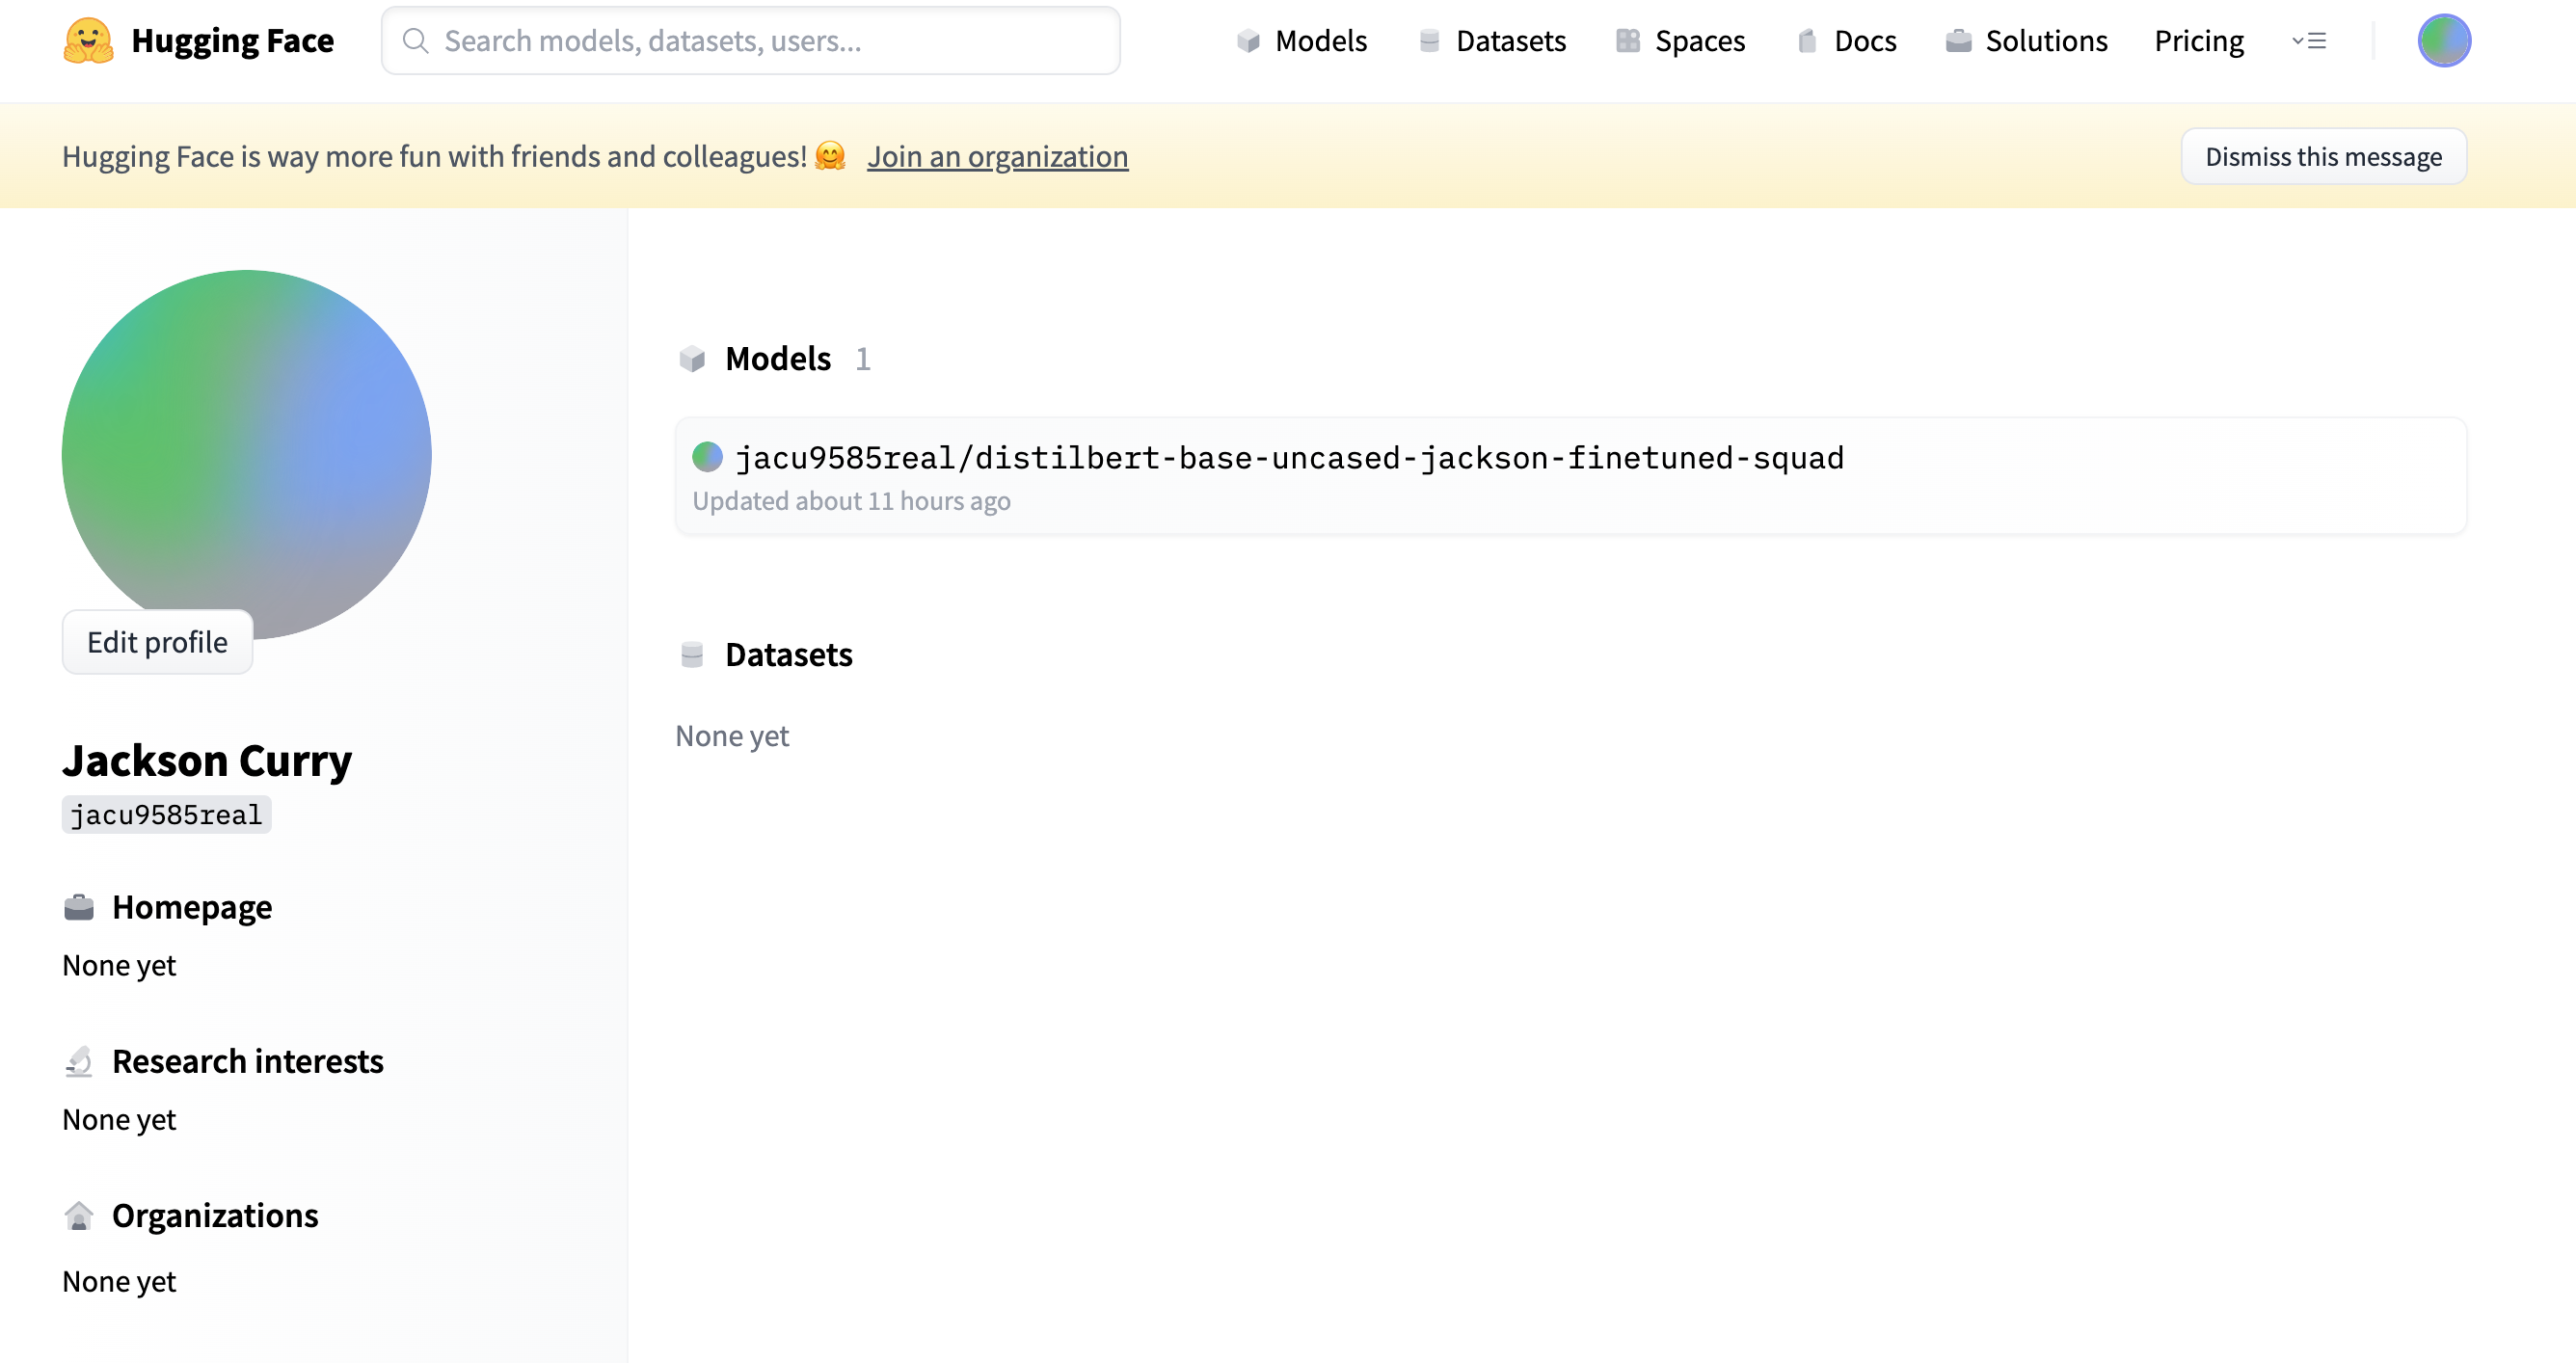